In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import time
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from version_model.model_list import *
from model_structure import save_model_structure
from plotting import plottingLossAcc, roc
from save_log import save_log

In [2]:
bins = {}
# normtype : minmax or std
normtype = 'std'
for i in range(1,10):
    bins[i] = np.load("/home/jua/SWGO/square/data/{}/bin{}.npz".format(normtype, i))    

In [3]:
n = 1
images = bins[n]['image'][:]
labels = bins[n]['label'][:]

images = torch.tensor(images).float()
labels = torch.tensor(labels).float()

sets = [(images[i],labels[i])for i in range(len(labels))]
shuffle(sets)

In [4]:
train_sets = sets[:int(len(sets)*0.8)]
valid_sets = sets[int(len(sets)*0.8):int(len(sets)*0.9)]
test_sets = sets[int(len(sets)*0.9):]

In [5]:
batchsize = 512
trainloader = torch.utils.data.DataLoader(train_sets, batch_size=batchsize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_sets, batch_size=batchsize, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_sets, batch_size=batchsize, shuffle=True, num_workers=2)
dataloader = {'train':trainloader, 'valid':validloader, 'test':testloader}
datasize = {'train': len(train_sets), 'valid':len(valid_sets), 'test':len(test_sets)}

In [6]:
print('# of Train : {}, # of valid : {}, # of Test : {}'.format(datasize['train'],datasize['valid'],datasize['test']))

# of Train : 102452, # of valid : 12807, # of Test : 12807


In [7]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        # print('Reset parameters of Linear')
        m.reset_parameters()

def freeze_conv(m):
    if isinstance(m, nn.Conv2d):
        # print('Freeze parameters of Conv2d')
        m.weight.requires_grad = False
        if m.bias is not None:
            m.bias.requires_grad = False

In [8]:
net = Model5()

if n > 9:
    net.load_state_dict(torch.load("save_model/best/best_B1_51220200527-151056.pth"))  
    net.apply(weight_init)
    net.apply(freeze_conv)

device=torch.device('cuda')
net.to(device)
net.eval()

Model5(
  (layer1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [9]:
learning_rate = 0.0003
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
#exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,verbose=True,patience=14)

In [10]:
threshold = 0.5
inputsize = 4
classes = {0:'gamma',1:'proton'}

In [11]:
def train_model(net, dataloader, criterion, optimizer, scheduler, n, batchsize, num_epochs=1, device=torch.device('cuda')):
    
    since = time.time()
    best_net_wts = net.state_dict()
    best_acc = 0.0
    
    losses = {'train':[],'valid':[]}
    accuracy = {'train':[],'valid':[]}
    
    for epoch in range(num_epochs):
        print( )
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train':
                net.train(True)
            else:
                net.eval()
                
            running_loss = 0.0
            running_corrects= 0
            ep_running_loss = 0.0
            ep_running_corrects = 0
            device = torch.device('cuda')
            for i, data in enumerate(dataloader[phase]):
                inputs, labels = data[0].to(device), data[1].to(device)
                if phase=='train':
                    optimizer.zero_grad()
                logits = net(inputs)
                outputs = logits.sigmoid()
                #outputs = net(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs>threshold
                loss = criterion(logits, labels.view(-1,1).float())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                                       
                running_loss += loss.data
                ep_running_loss += loss.data
                target = labels.view(-1,1)>threshold
                running_corrects += torch.sum(preds==target)
                ep_running_corrects += torch.sum(preds==target)
                               
                # Tensor Board 
                n_times = 10
                if i%n_times==9:
                    writer.add_scalar('{} loss'.format(phase),
                                     running_loss/(n_times),
                                     epoch*len(dataloader[phase])+i)
                    writer.add_scalar('{} Accuracy'.format(phase),
                                     float(running_corrects)/(n_times*batchsize),
                                     epoch*len(dataloader[phase])+i)                  
                    running_loss = 0.0
                    running_corrects = 0
                
            writer.close()
            epoch_loss = float(ep_running_loss)/float(len(dataloader[phase]))
            epoch_acc = float(ep_running_corrects)/float(datasize[phase])
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            print('{} Loss: {:.4f}, Acc : {:.4f}'.format( phase, epoch_loss, epoch_acc))    
            if phase == 'valid':
                scheduler.step(losses['valid'][-1])
                #scheduler.step()
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_net_wts = net.state_dict()
        
    print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Acc: {:4f}".format(best_acc))
    net.load_state_dict(best_net_wts)
    if best_acc > 0.85:
        modellogdir = "save_model/best/best_B{}_512".format(n) + now.strftime("%Y%m%d-%H%M%S") + ".pth"
        torch.save(net.state_dict(), modellogdir)
        save_log(losses, accuracy, num_epochs, n)
        save_model_structure(net, '5')
    return net,losses,accuracy    

In [12]:
def test(testloader,batchsize,device=torch.device('cuda')):
    correct = 0
    total = 0
    y_score = np.array([])
    y = np.array([])
    test_losses = []
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.view(-1,1)
        logits = net(inputs)
        outputs = logits.sigmoid()
        preds = outputs>threshold     
        loss = criterion(logits, labels.view(-1,1).float())
        y_score = np.append(y_score,outputs.data.cpu().detach().numpy())
        y = np.append(y,labels.cpu().numpy())
        test_losses.append(loss.data/batchsize)
        total += labels.size(0)
        target = labels.view(-1,1)>threshold
        correct += torch.sum(preds==target)
    return y, y_score, correct, total, test_losses

In [13]:
from datetime import datetime
now = datetime.now()
logdir = "runs/bin{}/".format(n) + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)
net,losses,accuracy = train_model(net, dataloader, criterion, optimizer,exp_lr_scheduler, n, batchsize, 40)


Epoch 0/39
----------
train Loss: 0.6713, Acc : 0.5858
valid Loss: 0.6401, Acc : 0.6284

Epoch 1/39
----------
train Loss: 0.5919, Acc : 0.6992
valid Loss: 0.5445, Acc : 0.7162

Epoch 2/39
----------
train Loss: 0.4897, Acc : 0.7661
valid Loss: 0.4567, Acc : 0.7805

Epoch 3/39
----------
train Loss: 0.4411, Acc : 0.7925
valid Loss: 0.4236, Acc : 0.8053

Epoch 4/39
----------
train Loss: 0.4192, Acc : 0.8058
valid Loss: 0.4199, Acc : 0.8065

Epoch 5/39
----------
train Loss: 0.4046, Acc : 0.8149
valid Loss: 0.4004, Acc : 0.8175

Epoch 6/39
----------
train Loss: 0.3925, Acc : 0.8215
valid Loss: 0.3883, Acc : 0.8178

Epoch 7/39
----------
train Loss: 0.3840, Acc : 0.8261
valid Loss: 0.3835, Acc : 0.8268

Epoch 8/39
----------
train Loss: 0.3761, Acc : 0.8308
valid Loss: 0.3717, Acc : 0.8331

Epoch 9/39
----------
train Loss: 0.3700, Acc : 0.8346
valid Loss: 0.3747, Acc : 0.8350

Epoch 10/39
----------
train Loss: 0.3630, Acc : 0.8389
valid Loss: 0.3662, Acc : 0.8386

Epoch 11/39
-------

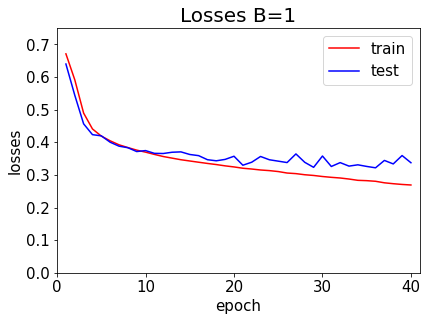

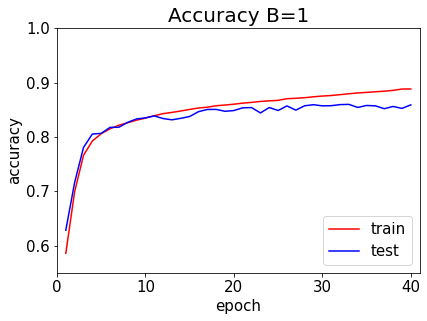

In [14]:
plottingLossAcc(losses,accuracy, n,(0,len(losses['train'])+1,0,0.75),(0,len(accuracy['train'])+1,0.55,1.0))

In [15]:
y,y_score,correct,total,test_losses = test(testloader,batchsize)

Accuracy of the network on the 12807 test images: 86 %


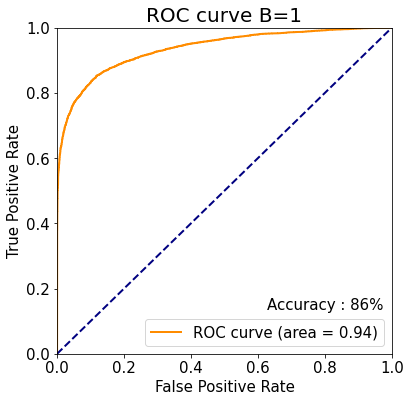

In [16]:
roc(y,y_score,correct,total,n)

In [17]:
sum(each.numel() for each in net.parameters() if each.requires_grad)

537857

In [18]:
51*51*4

10404

In [19]:
# [# of epoch] : 20
#modellogdir = "save_model/best/best_B{}_512".format(n) + now.strftime("%Y%m%d-%H%M%S") + ".pth"
#torch.save(net.state_dict(), modellogdir)
#save_log(losses, accuracy, 20, n)
#save_model_structure(net, '1')